## import libs

In [94]:
import string
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from nltk import FreqDist
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [95]:
df = pd.read_csv("Spam_SMS.csv")

In [96]:
df.head()

,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [97]:
df.isnull().sum()

Class      0
Message    0
dtype: int64

In [98]:
# Get most common words
all_words = []

for line in df["Message"]:
    words = line.split()
    for word in words:
        if len(word) > 2:
            all_words.append(word.lower())

Counter(all_words).most_common(50)

[('you', 1921),
 ('the', 1328),
 ('and', 968),
 ('for', 703),
 ('your', 677),
 ('have', 571),
 ('call', 559),
 ('are', 486),
 ('that', 470),
 ('but', 422),
 ('not', 410),
 ('can', 385),
 ('with', 379),
 ('will', 379),
 ("i'm", 377),
 ('get', 375),
 ('just', 365),
 ('this', 312),
 ('when', 283),
 ('from', 277),
 ('&lt;#&gt;', 276),
 ('all', 261),
 ('how', 254),
 ('what', 251),
 ('now', 247),
 ('like', 236),
 ('got', 235),
 ('know', 230),
 ('was', 230),
 ('free', 228),
 ('out', 220),
 ('come', 220),
 ('its', 208),
 ('then', 205),
 ('good', 201),
 ('send', 187),
 ('only', 184),
 ('want', 183),
 ('text', 175),
 ('time', 169),
 ("i'll", 168),
 ('love', 163),
 ('...', 163),
 ('going', 161),
 ('need', 157),
 ('about', 156),
 ('still', 151),
 ('one', 150),
 ('txt', 149),
 ('see', 145)]

## text preprocessing
 apply lemmatiztion 

In [99]:
stop_words = stopwords.words("english")


def text_preprocessing(text):
    # Make all words lowercase
    text = text.lower()

    # Remove  punction,number & spical char
    text = re.sub("[^a-zA-z]", " ", text)

    # Single char removel
    text = re.sub(r"\s+[a-zA-z]\s+", " ", text)

    # Remove multi spaces
    text = re.sub(r"\s+", " ", text)

    # Make a sentence to toknize
    tokens = word_tokenize(text)

    # Remove Stopwords
    final_token = [i for i in tokens if i not in stop_words]

    # Apply lemma
    final_words = []
    lemma = WordNetLemmatizer()
    for i in final_token:
        if len(i) > 2:
            word = lemma.lemmatize(i)
            final_words.append(word)
    return " ".join(final_words)

In [100]:
df["Clean_Text"] = df["Message"].apply(lambda x: text_preprocessing(x))
print("Text Preprocessing is done")

Text Preprocessing is done


In [101]:
df.head()

,Class,Message,Clean_Text
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis great world...
1,ham,Ok lar... Joking wif u oni...,lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win cup final tkts may te...
3,ham,U dun say so early hor... U c already then say...,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go usf life around though


In [102]:
df.drop(columns=["Message"], axis=1, inplace=True)
df.head()
x = df["Clean_Text"]
y = df["Class"]

In [103]:
text = " ".join(x.iloc[:5])

In [104]:
text

'jurong point crazy available bugis great world buffet cine got amore wat lar joking wif oni free entry wkly comp win cup final tkts may text receive entry question std txt rate apply dun say early hor already say nah think go usf life around though'

## Apply Feature Extraction

In [108]:
from sklearn.feature_extraction.text import CountVectorizer

binary_vectorization = CountVectorizer(binary=True)
binary_vectorized = binary_vectorization.fit_transform(df["Clean_Text"])

In [109]:
pd.DataFrame(
    binary_vectorized[:10].toarray(), columns=(binary_vectorization.vocabulary_.keys())
)

,jurong,point,crazy,available,bugis,great,world,buffet,cine,got,...,unit,accent,dental,nmde,dump,heap,lowes,salesman,pity,bitching
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
features = count_vect.fit_transform(df["Clean_Text"])

In [111]:
pd.DataFrame(features.toarray(), columns=count_vect.vocabulary_.keys())

,jurong,point,crazy,available,bugis,great,world,buffet,cine,got,...,unit,accent,dental,nmde,dump,heap,lowes,salesman,pity,bitching
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5571,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5572,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Apply tf-idf vec 

In [112]:
# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=5, max_df=0.8)
features = vec.fit_transform(df["Clean_Text"])

# split the data 

In [113]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, y, test_size=0.2, random_state=42
)

# train the random forest model 


In [125]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [126]:
y_pred = dt.predict(X_test)

In [127]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9542600896860987

In [128]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[922,  32],
       [ 19, 142]], dtype=int64)

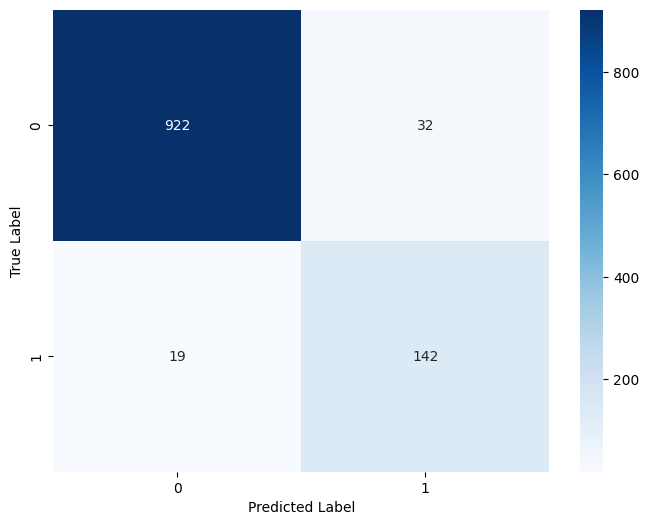

In [129]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [130]:
from sklearn.metrics import classification_report


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.98      0.97      0.97       954
        spam       0.82      0.88      0.85       161

    accuracy                           0.95      1115
   macro avg       0.90      0.92      0.91      1115
weighted avg       0.96      0.95      0.95      1115



# apply pos tagging 

In [131]:
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np


nltk.download("averaged_perceptron_tagger")


def pos_tag_text(text):
    """
    Apply POS tagging to text and return tagged string
    """
    # Tokenize the text
    tokens = word_tokenize(text)

    # Apply POS tagging
    tagged = pos_tag(tokens)

    # Join the words with their POS tags
    tagged_text = " ".join([f"{word}_{tag}" for word, tag in tagged])

    return tagged_text

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\elsay\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [132]:
# Add POS tagged text as a new feature
df["POS_Tagged"] = df["Clean_Text"].apply(pos_tag_text)

# Create features using both clean text and POS tagged text
tfidf_combined = TfidfVectorizer(
    max_features=5000, ngram_range=(1, 2), min_df=5, max_df=0.8
)

# Combine features from both clean text and POS tagged text
features_combined = tfidf_combined.fit_transform(
    df["Clean_Text"] + " " + df["POS_Tagged"]
)

In [133]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    features_combined, y, test_size=0.2, random_state=42
)

# Train the model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Make predictions
y_pred = dt.predict(X_test)

# Print results
print("\nAccuracy with POS tagging:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy with POS tagging: 0.9551569506726457

Classification Report:
              precision    recall  f1-score   support

         ham       0.98      0.97      0.97       954
        spam       0.81      0.89      0.85       161

    accuracy                           0.96      1115
   macro avg       0.90      0.93      0.91      1115
weighted avg       0.96      0.96      0.96      1115



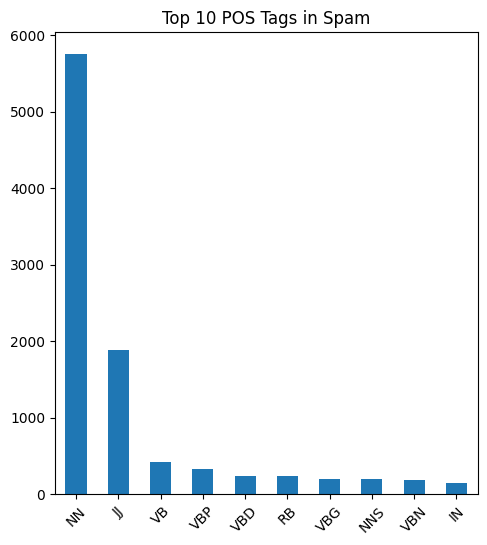

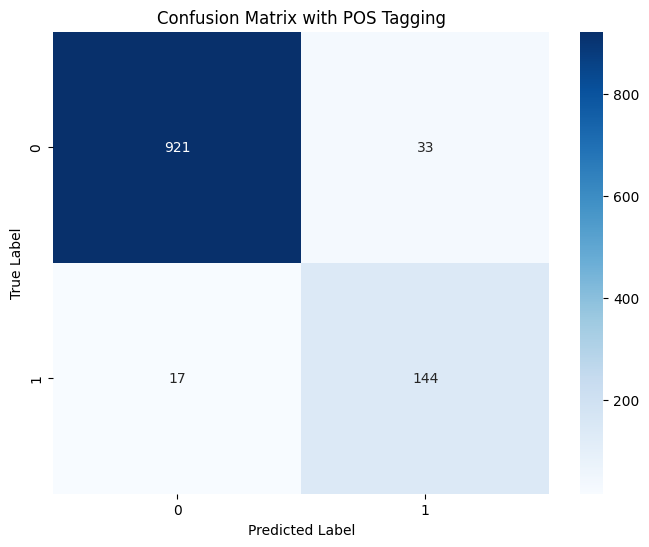


Example of POS tagged texts:

Original: jurong point crazy available bugis great world buffet cine got amore wat
Tagged: jurong_JJ point_NN crazy_NN available_JJ bugis_NN great_JJ world_NN buffet_NN cine_NN got_VBD amore_RB wat_JJ


In [134]:
# Plot POS distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
spam_pos.head(10).plot(kind="bar")
plt.title("Top 10 POS Tags in Spam")
plt.xticks(rotation=45)


# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix with POS Tagging")
plt.show()

# Example of POS tagged texts
print("\nExample of POS tagged texts:")
print("\nOriginal:", df["Clean_Text"].iloc[0])
print("Tagged:", df["POS_Tagged"].iloc[0])


# Analyze most common POS patterns in spam vs. non-spam
def get_pos_distribution(text_series):
    all_tags = []
    for text in text_series:
        tokens = word_tokenize(text)
        tagged = pos_tag(tokens)
        tags = [tag for word, tag in tagged]
        all_tags.extend(tags)
    return pd.Series(all_tags).value_counts()


# Get POS distributions for spam and non-spam
spam_pos = get_pos_distribution(df[df["Class"] == "spam"]["Clean_Text"])
ham_pos = get_pos_distribution(df[df["Class"] == "ham"]["Clean_Text"])

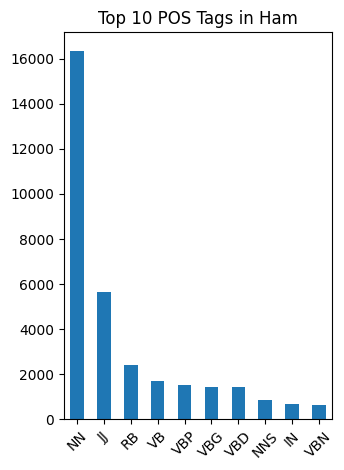

In [135]:
plt.subplot(1, 2, 2)
ham_pos.head(10).plot(kind="bar")
plt.title("Top 10 POS Tags in Ham")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()